In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
raw_df = pd.read_excel('../超市.xls')

In [4]:
# 编码
deliver_way_dict = {'当日': 1, '一级': 2, '二级': 3, '标准级': 4}
category_dict = {'办公用品': 1, '技术':2, '家具': 3}

sub_category_dict = {}
item_set = set()
for item in raw_df['子类别']:
    if item not in item_set:
        sub_category_dict[item] = len(item_set) + 1
        item_set.add(item)

maker_dict = {}
item_set = set()
for item in raw_df['制造商']:
    if item not in item_set:
        maker_dict[item] = len(item_set) + 1
        item_set.add(item)
        
area_dict = {
    '华北': 1,
    '东北': 2,
    '华东': 3, 
    '中南': 3, 
    '西南': 5, 
    '西北': 6
}

location_dict = {'华北': {},'东北': {},'华东': {},'中南': {}, '西南': {}, '西北': {}}

for i in range(len(raw_df['产品名称'])):
    area = raw_df['地区'][i]
    province = raw_df['省/自治区'][i]
    city = raw_df['城市'][i]
    if province not in location_dict[area].keys():
        location_dict[area][province] = {}
    location_dict[area][province][city] = 0

province_dict = {}
city_dict = {}

for key in location_dict.keys():
    p_dict = location_dict[key]
    count = 0
    for province in p_dict.keys():
        province_dict[province] = eval(str(area_dict[key]) + str(count))
        count += 1
    for province in p_dict.keys():
        c_dict = location_dict[key][province]
        count = 0
        for city in c_dict.keys():
            if count < 10:
                cnt_str = str('00') + str(count)
            elif count < 100:
                cnt_str = str('0') + str(count)
            city_dict[city] = eval(str(area_dict[key]) + str(province_dict[province]) + cnt_str)
            count += 1

In [5]:
# 按商品名提取特征
# 特征：平均发货时长，平均折扣，平均邮寄水平，类别，子类别，制造商
# 销售特征: 利润率，销售量，单价，利润
# 购买特征：主要面向客户，地域多样性，省多样性，市多样性

goods_dict = {}

for i in range(len(raw_df['订单 Id'])):
    # 商品销售相关特征
    name_index = raw_df['产品名称'][i].find(', ')
    #name = raw_df['产品名称'][i][:name_index]
    name = raw_df['产品名称'][i]
    deliver_time = (raw_df['发货日期'][i] - raw_df['订单日期'][i]).days
    discount = raw_df['折扣'][i]
    deliver_way = deliver_way_dict[raw_df['邮寄方式'][i]]
    category = category_dict[raw_df['类别'][i]]
    sub_category = sub_category_dict[raw_df['子类别'][i]]
    maker = maker_dict[raw_df['制造商'][i]]
    profit = raw_df['利润率'][i]
    sell_count = raw_df['数量'][i]
    price = (raw_df['销售额'][i]/sell_count)/(1-discount)
    profit_money = raw_df['利润'][i]
    
    # 用户相关特征
    user = raw_df['细分'][i]
    area = raw_df['地区'][i]
    province = raw_df['省/自治区'][i]
    city = raw_df['城市'][i]
    
    if name not in goods_dict.keys():
        main_user = {'消费者':0, '小型企业':0, '公司':0}
        goods_dict[name] = [[],[],[],category,sub_category,maker,
                            [],[],[],[],
                            main_user,{},{},{}
                           ]
    goods_dict[name][0].append(deliver_time)
    goods_dict[name][1].append(discount)
    goods_dict[name][2].append(deliver_way)
    goods_dict[name][6].append(profit)
    goods_dict[name][7].append(sell_count)
    goods_dict[name][8].append(price)
    goods_dict[name][9].append(profit_money)
    goods_dict[name][10][user] += sell_count
    if area not in goods_dict[name][11].keys():
        goods_dict[name][11][area] = sell_count
    else:
        goods_dict[name][11][area] += sell_count
    if province not in goods_dict[name][12].keys():
        goods_dict[name][12][province] = sell_count
    else:
        goods_dict[name][12][province] += sell_count
    if city not in goods_dict[name][13].keys():
        goods_dict[name][13][city] = sell_count
    else:
        goods_dict[name][13][city] += sell_count

In [6]:
goods_dict

{'Fiskars 剪刀, 蓝色': [[2, 7, 2, 4, 2, 5, 4, 5, 2, 3, 5],
  [0.4, 0.4, 0.0, 0.4, 0.0, 0.0, 0.0, 0.0, 0.4, 0.0, 0.0],
  [3, 4, 3, 4, 3, 4, 4, 3, 3, 2, 4],
  1,
  1,
  1,
  [-0.47, -0.47, 0.12, -0.47, 0.12, 0.12, 0.12, 0.12, -0.47, 0.12, 0.12],
  [2, 6, 5, 5, 3, 4, 3, 7, 7, 3, 4],
  [108.33333333333334,
   108.05555555555556,
   108.0,
   108.0,
   108.0,
   108.0,
   108.0,
   108.14285714285714,
   108.0952380952381,
   108.0,
   108.0],
  [-61, -182, 64, -152, 39, 52, 39, 90, -212, 39, 52],
  {'消费者': 30, '小型企业': 3, '公司': 16},
  {'华东': 13, '中南': 15, '西北': 4, '华北': 3, '西南': 7, '东北': 7},
  {'浙江': 8,
   '山东': 5,
   '湖北': 5,
   '湖南': 3,
   '陕西': 4,
   '天津': 3,
   '重庆': 7,
   '辽宁': 7,
   '广东': 7},
  {'杭州': 2,
   '温岭': 6,
   '潍坊': 5,
   '广水': 5,
   '岳阳': 3,
   '咸阳': 4,
   '天津': 3,
   '重庆': 7,
   '本溪': 7,
   '广州': 3,
   '惠州': 4}],
 'GlobeWeis 搭扣信封, 红色': [[4, 4, 2, 7],
  [0.0, 0.0, 0.0, 0.0],
  [4, 3, 3, 4],
  1,
  2,
  2,
  [0.34, 0.34, 0.34, 0.34],
  [2, 3, 4, 2],
  [62.5, 62.666666666666664, 6

In [7]:
right = 0
data_df = {'name':[], 'deliver_time':[],'discount':[],'deliver_way':[],'category':[],'sub_category':[],'maker':[],
           'price':[],'profit':[],'sell_count':[], 'profit_money':[],
           'main_user':[],'area_div':[],'province_div':[],'city_div':[],
           'label':[]}
for key in goods_dict.keys():
    data_df['name'].append(key)
    time_avr = np.mean(goods_dict[key][0])
    discount_avr = np.mean(goods_dict[key][1])
    deliver_way_avr = np.mean(goods_dict[key][2])
    profit_avr = np.mean(goods_dict[key][6])
    sell_count_avr = np.mean(goods_dict[key][7])
    price_avr = np.mean(goods_dict[key][8])
    profit_money_avr = np.mean(goods_dict[key][9])
    data_df['deliver_time'].append(time_avr)
    data_df['discount'].append(discount_avr)
    data_df['deliver_way'].append(deliver_way_avr)
    data_df['profit'].append(profit_avr)
    data_df['sell_count'].append(sell_count_avr)
    data_df['price'].append(price_avr)
    data_df['profit_money'].append(profit_money_avr)
    
    data_df['category'].append(goods_dict[key][3])
    data_df['sub_category'].append(goods_dict[key][4])
    data_df['maker'].append(goods_dict[key][5])
    
    main_user = 0
    total_cnt = sum(goods_dict[key][7])
    avr_cnt = total_cnt / 3
    if goods_dict[key][10]['消费者'] > avr_cnt:
        main_user += 100
    if goods_dict[key][10]['小型企业'] > avr_cnt:
        main_user += 10
    if goods_dict[key][10]['公司'] > avr_cnt:
        main_user += 1
    data_df['main_user'].append(main_user)
    
    area_div = len(goods_dict[key][11].keys()) / total_cnt
    data_df['area_div'].append(area_div)
    
    province_div = len(goods_dict[key][12].keys()) / total_cnt
    data_df['province_div'].append(province_div)
    
    city_div = len(goods_dict[key][13].keys()) / total_cnt
    data_df['city_div'].append(city_div)
    
    if profit_money_avr > 0:
        data_df['label'].append(1)
        right += 1
    else:
        data_df['label'].append(0)

In [8]:
pd.DataFrame(data=data_df)

,name,deliver_time,discount,deliver_way,category,sub_category,maker,price,profit,sell_count,profit_money,main_user,area_div,province_div,city_div,label
0,"Fiskars 剪刀, 蓝色",3.727273,0.145455,3.363636,1,1,1,108.056999,-0.094545,4.454545,-21.090909,100,0.122449,0.183673,0.224490,0
1,"GlobeWeis 搭扣信封, 红色",4.250000,0.000000,3.500000,1,2,2,62.604167,0.340000,2.750000,58.750000,100,0.272727,0.363636,0.363636,1
2,"Cardinal 孔加固材料, 回收",4.000000,0.166667,3.500000,1,3,3,26.611508,0.334167,4.333333,36.416667,101,0.076923,0.173077,0.230769,1
3,"Kleencut 开信刀, 工业",2.250000,0.300000,2.500000,1,1,4,133.750000,0.027500,2.750000,34.750000,1,0.363636,0.363636,0.363636,1
4,"KitchenAid 搅拌机, 黑色",2.571429,0.114286,2.714286,1,4,5,458.603175,0.285714,3.428571,497.857143,101,0.166667,0.250000,0.291667,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1948,"Barricks 会议桌, 组装",5.000000,0.600000,3.000000,3,17,65,4240.000000,-0.350000,4.000000,-2374.000000,100,0.250000,0.250000,0.250000,0
1949,"SanDisk 令, 回收",5.000000,0.000000,4.000000,1,7,14,138.555556,0.110000,9.000000,136.000000,100,0.111111,0.111111,0.111111,1
1950,"Chromcraft 圆桌, 长方形",4.000000,0.250000,3.000000,3,17,64,2168.333333,-0.150000,4.000000,-954.000000,1,0.250000,0.250000,0.250000,0
1951,"Kleencut 大剪刀, 工业",4.000000,0.000000,4.000000,1,1,4,226.000000,0.000000,2.000000,0.000000,1,0.500000,0.500000,0.500000,0


/Users/suzyyy/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/suzyyy/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/suzyyy/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/suzyyy/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

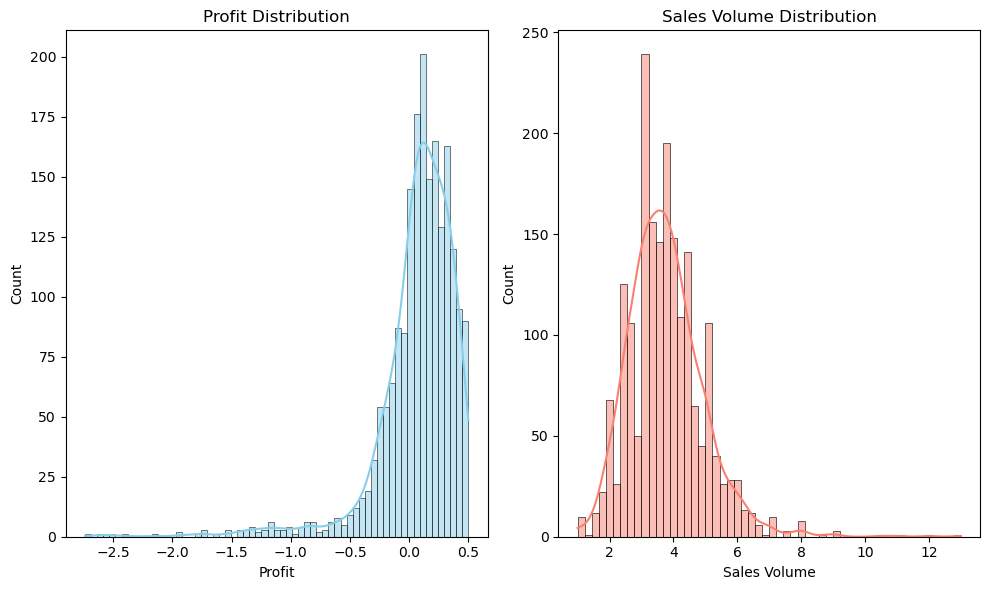

In [9]:
data = pd.DataFrame({'Profit': data_df['profit'], 'Sales Volume': data_df['sell_count']})

# 使用seaborn和matplotlib绘制分布图
plt.figure(figsize=(10, 6))

# 利润率的分布图
plt.subplot(1, 2, 1)
sns.histplot(data['Profit'], kde=True, color='skyblue')
plt.title('Profit Distribution')

# 销量的分布图
plt.subplot(1, 2, 2)
sns.histplot(data['Sales Volume'], kde=True, color='salmon')
plt.title('Sales Volume Distribution')

plt.tight_layout()
plt.show()

In [25]:
df = pd.DataFrame(data=data_df)
df.to_csv('./Data/full_name_all_feature_with_label.csv',index=None)